<h1 align="center">Interpretación automatizada de registros geofísicos de pozos</h1> 
_______________________________________________________________________________________________________________________________


<h5 align="center">Luis Terán</h5> 

La aplicación web completa se encuentra disponible en:

</br><center> https://registro-pozos-turae.herokuapp.com/</center>

El objetivo de este proyecto es obtener un método tal que la computadora sea capaz de realizar una interpretación de registros geofísicos de manera automática y sin intervención humana alguna dado un set de datos que contenga registros geofísicos.

Para mayor información, leer la descripción disponible en este repositorio

## Lectura de datos

Al iniciar la ejecución del programa se solicitan diversos parámetros para elaborar la corrección e interpretación de los registros en cuestión, en caso de no ser ingresados se asignarán valores que no ejecutan ninguna corrección a los datos o bien, que permitan la ejecución del programa. 

In [97]:
import las
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans, MeanShift

log = las.LASReader('buena1.las')
dat=pd.DataFrame(data=log.data, columns=log.curves.names)
dat=dat.replace(-999.00000,0.0)
dat=dat.replace(-9999.00000,0.0)

In [98]:
dat.columns

Index(['DEPTH', 'CALI', 'CGR', 'DPHI', 'DRHO', 'LLD', 'NPHI', 'PEF', 'POTA',
       'RHOB', 'SGR', 'SP', 'THORIUM', 'URAN'],
      dtype='object')

## Funciones utilizadas

In [99]:
#Buscar curvas 
def buscarCurva(tipo, dicNombres, dh, unidad=False):    
    for nombre in dicNombres[tipo]["nombre"]:
        i=0
        for curva in dh.Nombre.values:
            i+=1
            #print (nombre, curva)
            if (nombre in curva):
                #print('Se encontró un valor por nombre')
                return i-1    
    for desc in dicNombres[tipo]["desc"]:
        i=0
        for curva in dh.Descripcion.values:  
            #print(desc, curva)
            if (desc in curva):
                #print('Se encontró un valor por descripción')
                return i-1            
    if (unidad):
        for unidadad in dicNombres[tipo]["unidad"]:
            i=0
            for curva in dh.Unidades.values:  
                i+=1
                #print(desc, curva)
                if (unidad in curva):
                    #print('Se encontró un valor por descripción')
                    return i-1

#Cálculos

#Temperatura
def calcTempIntervalo(bht, ts, pm, cprof):
    ti= (((bht-ts)/pm)*cprof) + ts
    return ti

#RESISTIVIDAD

def calcRi(resistividad,curvaTemp,ts):
    #resistividad puede ser rmf, rmc, rm
    #6.77 es en Farenheit si TS está en grados debe cambiarse por 21.5
    Rint=resistividad*((ts+6.77)/(curvaTemp+6.77))
    return Rint

def calcRmfEq(Rmfi, tf):
    temp1=Rmfi*(10**((0.426)/(np.log((tf)/(50.8)))))
    temp2=(1)/(np.log((tf)/(19.9)))
    temp3=0.131*(10**((temp2)-2))
    Rmfe=(temp1-temp3)/(1+(0.5*Rmfi))
    return Rmfe

def calcRwEq(Rmfe, SSP):
    #Está en Farenheit
    #!!!!!!!!!!!!!!!!!!!!checar antes de entregar!!!!!!!!!!!!!!!!!!!!
    K=65+0.24
    Rwe = 10 ** ((K*np.log(Rmfe) + SSP)/(K))
    return Rwe

def calcRw(Rwe, bht):
    temp1=Rwe + (0.131 * 10 ** ((1/(np.log(bht/19.9)))-2))
    temp2=-0.5*Rwe + (10**((0.0426)/(np.log(bht/50.8))))
    Rw=temp1/temp2
    return Rw

def calcRxo(curvaProf, curvaSom):
    arr = abs(curvaProf-curvaSom)
    result = np.where(arr == np.amax(arr))
    return curvaSom[result[0][0]]

#VOLUMEN DE ARCILLA
def calcVArcilla(GR, metodo):
    IGR=(GR-min(GR))/(max(GR)-min(GR))
    if metodo == 'lineal':
        return IGR
    elif(metodo == 'larinovj'):
        Vsh = 0.083*((2 ** (3.71*IGR))-1)
        return Vsh
    elif(metodo == 'clavier'):
        Vsh = 1.7 * math.sqrt((3.38)*((IGR +0.7)**2))
        return Vsh
    elif (metodo=='larinovv'):
        Vsh = 0.33*((2 ** (2*IGR))-1)
        return Vsh

#CORRECCIÓN DE POROSIDAD
def calcCurvaPorDen(pma, pf, RHOB):    
    #Curva de porosidad densidad
    pord= (pma - RHOB)/(pma - pf)
    #pord>1=1
    return pord

#Curva de porosidad total
def calcPorTot(pord, NPHI):
    port = (pord - NPHI)/2
    return port

#Curva de porosidad primaria o de matriz
def calcPorP(lma, lfl, DT):
    porp = (DT - lma)/(lfl - lma)
    return porp

#Curva de porosidad efectiva
def calcPorEfec(port, Vsh):
     return (port*(1-Vsh))

#Saturaciones
def calcSw(a,m,n,Rw,Rt,por):
    temp1=Rt*((por)**m)
    Sw = ((a*Rw)/(temp1))**(1/n)
    return Sw

def calcSxo(a,m,n,Rxo,Rmf,por):
    temp1=Rxo*((por)**m)
    Sxo = ((a*Rmf)/(temp1))**(1/n)
    return Sxo

#Separación de capas
def evaluarScore(score, porc):
    temp=100
    for i in range (len(score)):
        temp = abs((abs(score[i]) - abs(score[i+1]))*(100/score[i]))
        print (temp)
        if (temp<porc):
            return i+1
        if (i==(len(score)-1)):
            return i+1

#Clasificación litológica
def crearCurvas():
    pArena = np.array([[-1.5,2.66],[-1,2.64],[0.5, 2.605],[2,2.57],[5,2.51],[8,2.46],[10,2.43],[20,2.26],[25, 2.18],[31,2.08],[36,2.0],[40.5,1.92]])
    pCaliza = np.array([[3, 2.66],[36,2.1]])
    pDolomita = np.array([[4, 2.86],[8.5,2.82],[13, 2.76],[18,2.68],[23,2.59],[27,2.5],[32,2.4],[36,2.3],[38, 2.26],[41,2.18],[44,2.1]])
    pLutita = np.array([[30, 2.8],[40, 2.6],[41, 2.5]])
    
    arena=[]
    caliza = []
    dolomita = []
    lutita=[]

    za = np.polyfit(pArena[:,0], pArena[:,1], 5)
    pa = np.poly1d(za) 

    zc = np.polyfit(pCaliza[:,0], pCaliza[:,1], 1)
    pc = np.poly1d(zc)

    zd = np.polyfit(pDolomita[:,0], pDolomita[:,1], 5)
    pd = np.poly1d(zd)
    
    zl = np.polyfit(pLutita[:,0], pLutita[:,1], 1)
    pl = np.poly1d(zl)

    for i in range(45):
        arena.append([0.93*i-1.5, pa(0.93*i -1.5)])
        caliza.append([1*i, pc(1*i)])
        dolomita.append([0.94*i+2.5, pd(0.94*i +2.5)])
    for i in range(20):
        lutita.append([0.7*i+30, pc(1*i) + 0.1])

    arena=np.array(arena)
    caliza=np.array(caliza)
    dolomita=np.array(dolomita)
    lutita = np.array(lutita)
    
    return (arena, caliza, dolomita, lutita)

def e_dist(a, b, metric='euclidean'):
    a = np.asarray(a)
    b = np.atleast_2d(b)
    a_dim = a.ndim
    b_dim = b.ndim
    if a_dim == 1:
        a = a.reshape(1, 1, a.shape[0])
    if a_dim >= 2:
        a = a.reshape(np.prod(a.shape[:-1]), 1, a.shape[-1])
    if b_dim > 2:
        b = b.reshape(np.prod(b.shape[:-1]), b.shape[-1])
    diff = a - b
    dist_arr = np.einsum('ijk,ijk->ij', diff, diff)
    if metric[:1] == 'e':
        dist_arr = np.sqrt(dist_arr)
    dist_arr = np.squeeze(dist_arr)
    return dist_arr

def clasificarLito(arena, caliza, dolomita, lutita, dato1, dato2):
    minimo=[]
    
    tarena=np.copy(arena)
    tcaliza=np.copy(caliza)
    tdolomita=np.copy(dolomita)
    tlutita=np.copy(lutita)
    
    tarena[:,0]=arena[:,0]/10
    tcaliza[:,0]=caliza[:,0]/10
    tdolomita[:,0]=dolomita[:,0]/10
    tlutita[0][0]=lutita[0][0]/10
    dato1=dato1/10
    
    minArena=(e_dist([dato1,dato2],tarena))
    minCaliza=(e_dist([dato1,dato2],tcaliza))
    minDolomita=(e_dist([dato1,dato2],tdolomita))
    minLutita=(e_dist([dato1,dato2],tlutita))

    minimo.append(min(minArena))
    minimo.append(min(minCaliza))
    minimo.append(min(minDolomita))
    minimo.append(min(minLutita))    
    
    #return minimo
    
    if np.argmin(minimo)==0:
        mini = np.argmin(minArena)
        return ("Arena",mini)
    elif np.argmin(minimo)==1:
        mini = np.argmin(minCaliza)
        return ("Caliza",mini)
    elif np.argmin(minimo)==2:
        mini = np.argmin(minDolomita)
        return ("Dolomita",mini)
    elif np.argmin(minimo)==3:
        mini = 0
        return ("Lutita",mini)
    
def dibujarRegistros(df):
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns.values), figsize=(20,10), sharey=True)
    fig.suptitle("Registros geofísicos de pozos", fontsize=22)
    fig.subplots_adjust(top=0.75,wspace=0.2)
    i=0
    
    if 'Clasif' in df.columns:
        for registro in (df.columns.values[:-1]):        
            color='black'
            ax10=ax[i].twiny()
            #ax10.set_xlim(min(df[registro]),max(df[registro]))
            #ax10.spines['top'].set_position(('outward',0))
            ax10.plot(df[registro],df.index.values, color=color)
            ax10.set_xlabel(registro+' ['']',color=color)    
            #ax10.tick_params(axis='x', colors=color)
            ax10.invert_yaxis()
            ax10.grid(True)
            i+=1        
        ax10=ax[len(df.columns)-1].twiny()
        a = df.Clasif.values
        data=df.Clasif.values.reshape(len(df.Clasif.values), 1)
        cmap = plt.get_cmap('Dark2', np.max(data)-np.min(data)+1)        
        mat = ax10.matshow(np.repeat(data, 300, 1),cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)        
        cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))            
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        ax10.set_xlabel(registro+' ['']',color=color)    
        #ax.figure.set_size_inches(300, 500)
        #ax10.tick_params(axis='x', colors=color)
        ax10.invert_yaxis()
        ax10.grid(True)
        i+=1
         
    else:
        for registro in (df.columns.values):        
            color='black'
            ax10=ax[i].twiny()
            #ax10.set_xlim(min(df[registro]),max(df[registro]))
            #ax10.spines['top'].set_position(('outward',0))
            ax10.plot(df[registro],df.index.values, color=color)
            ax10.set_xlabel(registro+' ['']',color=color)    
            #ax10.tick_params(axis='x', colors=color)
            ax10.invert_yaxis()
            ax10.grid(True)
            i+=1


## Identificación de curvas

Del archivo leído, dentro del cuadro descriptivo de este aspecto se extrae el nombre de las curvas, sus unidades respectivas y su descripción.
Posteriormente, se declara un diccionario que contiene posibles nombres, palabras clave o mnemónicos utilizados para describir el nombre de las curvas, así como las posibles unidades de las curvas y descripciones relacionadas con las curvas.
Para la identificación de las curvas se revisa por cada elemento en el diccionario la identificación de caracteres que se relacione con los nombres de las curvas extraídos de los archivos. 
La identificación se realiza con base en identificación de caracteres contenidos o bien, con el mnemónico de su clase. 


In [100]:
#Se guarda el header en un diccionario
dic=log.curves.items

#Se crean arreglos de nombre, unidades y descripción
ldescr = []
lunidades = []
lnombres=log.curves.names

#Se guardan los datos dentro del arreglo
for i in range (len(lnombres)):
    ldescr.append(dic[log.curves.names[i]].descr.upper())
    lunidades.append(dic[log.curves.names[i]].units.upper())   

data = {"Nombre": lnombres, "Descripcion": ldescr, "Unidades": lunidades}
dh = pd.DataFrame(data)

In [101]:
dicNombres = {
    "profundidad": {
        'nombre' : ["DEPT", "DEPTH", "MD"],
        'desc' : ["DEPT", "DEPTH"],
        #FALSE
        'unidad' : ["FT", "M"]
    },
    "caliper": {
        'nombre' : ["CALIPER", "CALI","CAL","DAC","MSC","CL","TAC","MCT","EMS","CCT","XYT","CCN","DNSC","DSNCM"],
        'desc' : ["CALIPER", "CALI"],
        'unidad' : ["IN"]
    },
    "sp": {
        'nombre' : ["SP"],
        'desc' : ["SP", "SPONTANEUS", "POTENCIAL"],
        'unidad' : ["MV", "V"]
    },
    "gr": {
        'nombre' : ["GR","MCG","MGS","NGS","NGT","IPL","GRT","DGR","DG","SL","HDS1","RGD","CWRD","SGR"],
        'desc' : ["GR", "GAMMA", "RAY"],
        'unidad' : ["GAPI", "API"]
    },
    "rhob": {
        'nombre' : ["RHOB", "APLS", "ZDL", "CDL", "SPeD", "SDL","PDS", "MPD","IPL","CDT","LDT","ORD","MDL","DNSC","ASLD"],
        'desc' : ["DENSITY","RHOB", "RHO"],
        'unidad' : ["G/C3"]
    },
    "nphi": {
        'nombre' : ["NPHI", "NPH", "CN","DSN","DSEN","MDN","IPL","CNT","CCN","MNP","DNSC","CTN"],
        'desc' : ["NEUTRON","NEUT"],
        #FALSE
        'unidad' : ["V/V"]
    },
    "rsom": {
        'nombre' : ["LL3","SGRD","SFL","SLL","LLS","RLLS"],
        'desc' : ["SHALL"],
        #FALSE
        'unidad' : ["OHMMxxx"]
    },
    "rmed": {
        'nombre' : ["R60O","ILM","RILM"],
        'desc' : ["MEDR","MED"],
        #FALSE
        'unidad' : ["OHMMxxxx"]
    },
    "rprof": {
        'nombre' : ["R85O","ILD","RILD","DLL","LLD","RLLD"],
        'desc' : ["DEEPR","DEEP"],
        #FALSE
        'unidad' : ["OHMMxxxx"]
    },
    "dt": {
        'nombre' : ["DT","APX","XMAC","DAL","AC","BCS","DAR","FWS","XACT","CSS","LCS","MSS","UGD","DSI","CST","LST","DNSC","SONIC","BAT"],
        'desc' : ["DT","SONIC"],    
        'unidad' : ["US/F"]
    },  
}

## Revisión de datos disponibles y procedimiento a seguir

Una vez realizada la identificación de curvas, se realiza una revisión de que curvas se pudieron encontraron y cuales no pudieron ser identificadas, ya sea por falla del programa o porque no se encontraba el registro en el archivo LAS.
Con base en el registro de curvas identificadas se determina qué cálculos y gráficas se podrán realizar a lo largo del programa restante, así como los resultados que se entregarán.


In [102]:
n1 = ['DEPTH','CALIPER', 'GR', 'SP', 'RHOB', 'NPHI', 'RCERC','RMED', 'RPROF', 'DT']
n2 = ['profundidad','caliper','gr','sp','rhob','nphi', 'rsom', 'rmed', 'rprof', 'dt']
noSePuede = []
data={}

for i in range(len(n1)):
    try:
        data[n1[i]] = dat[log.curves.names[buscarCurva(n2[i], dicNombres, dh)]]
        print ('Se encontró la curva '+n2[i])
    except:
        noSePuede.append(n1[i])
        print ('No se han encontrado '+n2[i])

Se encontró la curva profundidad
Se encontró la curva caliper
Se encontró la curva gr
Se encontró la curva sp
Se encontró la curva rhob
Se encontró la curva nphi
No se han encontrado rsom
No se han encontrado rmed
Se encontró la curva rprof
No se han encontrado dt


In [103]:
calcularSat=True
calcularXPlot=True
calcularRw = True
calcularVsh = True
calcularRxo = True
calcularPort = True
calcularPore = True
calcularSw = True
calcularSxo = True

if ('DEPTH' in noSePuede or 'SP' in noSePuede):
    calcularRw = False
    calcularSat = False
    calcularSw = False
if ('RPROF' in noSePuede):
    calcularSat = False
    calcularSw = False
if ('RHOB' in noSePuede or 'NPHI' in noSePuede):
    calcularXPlot = False
    calcularPort = False
    calcularSw = False
    calcularSxo = False
if ('GR' in noSePuede):
    calcularVsh = False
    calcularPore = False
if ('RCERC' in noSePuede):
    calcularRxo = False
    calcularSxo = False


## Corrección y cálculo de curvas

En la etapa de corrección de curvas, debido a la complicación que estas generaban, decidimos optar por la aplicación de correcciones de manera simplificada. Es decir, que el factor de corrección necesario sea obtenido de manera manual mediante aplicación de tablas para posteriormente aplicarse directamente a los registros del archivo


In [104]:
df = pd.DataFrame(data=data) 

In [105]:
#Valores a ingresar

#GR
#Ingrese el factor de corrección para el registro de GR
#Se recomienda usar "Schlumberger - Log Interpretation charts"
##Sección 2-1, 2-2, 2-3
fgr = 1

#SP
#Ingrese el factor de corrección para el registro SP
#Se recomienda usar "Schlumberger - Log Interpretation charts"
##Sección 2-5, 2-6, 2-7, 2-8, 2-9, 2-10
fsp=1

#Densidad 
#Ingrese el factor de corrección para el registro de densidad
#Se recomienda usar "Schlumberger - Log Interpretation charts"
fp=0.0

#NPHI
#Ingrese el factor de corrección para el registro de densidad
#Se recomienda usar "Schlumberger - Log Interpretation charts"
fnphi=0.0

#Resistividad 
#Ingrese el factor de corrección para los registros de resistividad
#Se recomienda usar "Schlumberger - Log Interpretation charts"
#Sección 6-1,6-2,6-3,6-5,6-7
frsom = 1
frmed = 1
frprof = 1

#Salinidad
salinidad = 100

#Para corrección de porosidad
#Densidad de matriz
pma= 2.45
#Densidad de fluido
pf= 1.7

#Para porosidad primaria
#Lentitudes
#Se necesita lentitud:
lma = 120.0
lfl = 80.0

#Factor de tortuosidad
a=1.0

#Exponente de cementación
m=2

#Exponente de saturación
n=2

#Método para calcular volumen de arcilla
metodo='lineal'

#Evaluación del score
es = 30

#Se conocen clusters
kc= -1

#Número de clusters
nc=-1

In [106]:
#Datos del archivo .LAS
try:
    rmf=float(log.parameters.RMF.data)
except: 
    rmf=0.95
try:
    rmc=float(log.parameters.RMC.data)
except: 
    rmc=1.55
try:
    rm=float(log.parameters.RM.data)
except: 
    rm=1.13
try:
    bht=float(log.parameters.BHT.data)
except: 
    bht=3000
try:
    ts=float(log.parameters.MST.data)
except: 
    ts=3000
    
pm=max(df.DEPTH)

In [107]:
#Aplicación de correcciones
if ('GR' in df.columns):
    df['GR']=df['GR']*fgr
if ('SP' in df.columns):
    df['SP']=df['SP']*fsp
if ('RHOB' in df.columns):
    df['RHOB']=df['RHOB']+fp
if ('NPHI' in df.columns):
    df['NPHI']=df['NPHI']+fnphi
if ('RCERC' in df.columns):
    df['RCERC']=df['RCERC']*frsom
if ('RMED' in df.columns):
    df['RMED']=df['RMED']*frmed
if ('RPROF' in df.columns):
    df['RPROF']=df['RPROF']*frprof

In [108]:
df1 = df[df.columns[1:]].copy()

In [109]:
calcularXPlot=True

if (calcularVsh):
    df['VSH']=calcVArcilla(df.GR, metodo)

if (calcularPort):
    pord=calcCurvaPorDen(pma, pf, df.RHOB)
    df['PTOT']=calcPorTot(pord, df.NPHI)

if (calcularPore):
    df['PEfec']=calcPorEfec(df.PTOT, df.VSH)
    
if (calcularRw):
    df['TEMP']=calcTempIntervalo(bht, ts, pm, df.DEPTH)
    curvaRmf = calcRi(rmf, df.TEMP, ts)
    tf = df.TEMP.values[df.SP.idxmin()]
    rmEq = calcRmfEq(curvaRmf, tf)
    rwEq = calcRwEq(rmEq, df.SP)
    curvaRw=calcRw(rwEq, bht)
    Rw=curvaRw[df.SP.idxmin()]

if (calcularRxo):
    Rxo = calcRxo(df['RPROF'], df['RCERC'])
    
if (calcularSw):
    df['Sw']=calcSw(a,m,n,Rw, df['RPROF'],df['PTOT'])

if (calcularSxo):
    df['Sxo']=calcSxo(a,m,n,Rxo,rmf,df['PTOT'])
    

## Clasificación

Esto se realizó mediante algoritmos de Machine Learning de clasificación no supervisada utilizando dos enfoques diferentes:

- El primer enfoque (Algoritmo de K-means) parte de la idea de que se conoce el número de litologías presentes, y por lo tanto el número de agrupaciones de puntos, por lo que es necesario adaptar el modelo a la información establecida. Por esa misma razón, es posible obtener resultados más precisos.
- El segundo enfoque (Algoritmo de Mean Shift) toma la idea de que no se conoce el número de litologías presentes, por lo que automáticamente se determinará el número de agrupaciones, pero con menor precisión.

Previo a la aplicación de los algoritmos es necesario aplicar una normalización de los datos para fomentar la convergencia de los algoritmos. Esto es, que cada rango de variación de los registros sea de 0 – 1.


In [110]:
#Se crea un dataframe y se realiza un preprocesamiento para su clasificación
x = df1.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df1nor = pd.DataFrame(x_scaled)
df1nor.columns = df1.columns

In [111]:
# #Se obtiene un arreglo de datos del dataframe de datos normalizados
X=np.array(df1nor)

In [112]:
# Se obtiene una predicción del modelo por cada muestra
if (kc == -1):
    #Se ajusta el número de clusters con la información del dataframe    
    labels=MeanShift().fit_predict(X)    
else:
    kmeans = KMeans(n_clusters=kc).fit(X)
    centroides = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    
#Se agrega la clasificación realizada al dataframe original
df['Clasif'] = labels
#Se cuenta el número de clusters 
ncl=len(np.unique(labels))

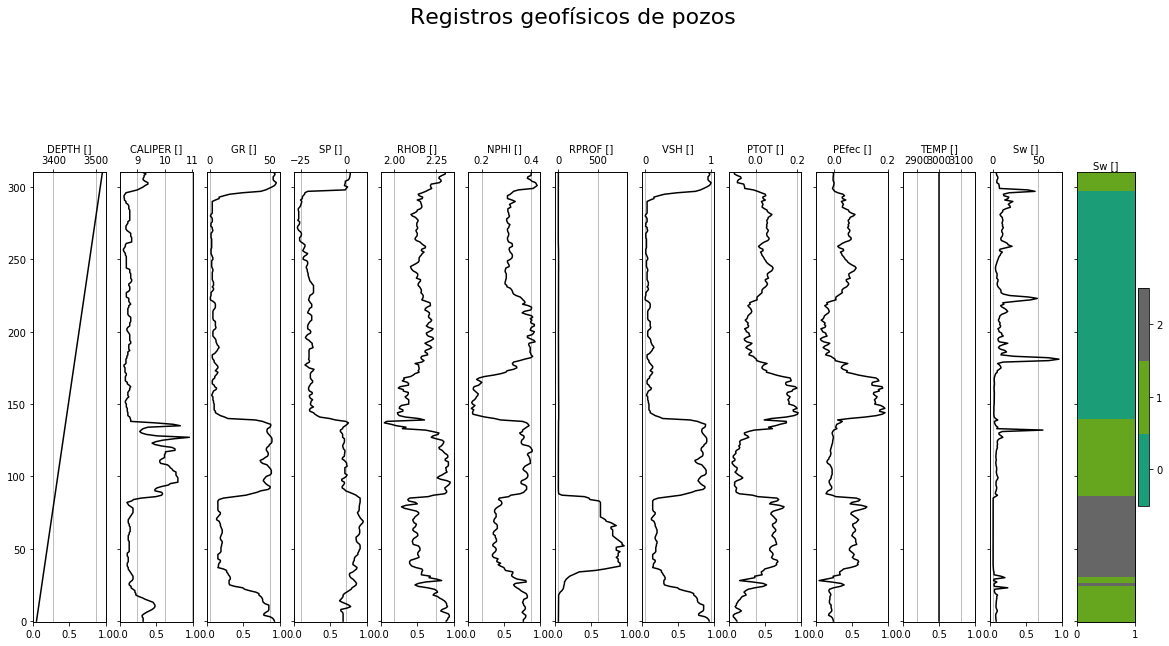

In [113]:
dibujarRegistros(df)

## Identificación de litología

Una vez realizado este proceso, es posible diferenciar cada una de las capas. No obstante, se desconoce aún a cuál litología pertenecen. Para determinar a qué litología pertenecen se reconstruyó el crossplot de densidad contra porosidad de neutrón.

Como paso inicial, se obtuvieron los valores promedio de las propiedades para cada agrupación obtenida, incluyendo aquellos que se repiten en intervalos separados. 

Para obtener el crossplot, manualmente se observaron aproximadamente doce puntos en la gráfica de cada una de las líneas y se realizó una interpolación polinomial de 5° grado. Una vez obtenidos los coeficientes de la curva, se remuestrearon las curvas con 45 puntos obteniendo la representación completa de las curvas.

Posteriormente, los valores promedio de densidad y porosidad de neutrón de cada agrupación son colocados en el crossplot. Para identificar a qué curva pertenecen, se calcula la distancia euclidiana con cada uno de los puntos de muestreo de las curvas y se elige aquel que tiene una menor distancia al punto. Y así, se obtiene la información de a qué litología pertenece.

In [114]:
#Creación de puntos de clasificación
ptos = np.zeros(shape=(ncl,2))

for i in range (ncl):
    temp=df[df.Clasif == i]['RHOB'].mean()
    temp2=df[df.Clasif == i]['NPHI'].mean()
    ptos[i]=[temp, temp2]    
    
if (max(abs(ptos[:,1]))<1):
    ptos[:,1]=ptos[:,1]*100

In [116]:
#Se crean las curvas de cada litología
[arena, caliza, dolomita, lutita]=crearCurvas()

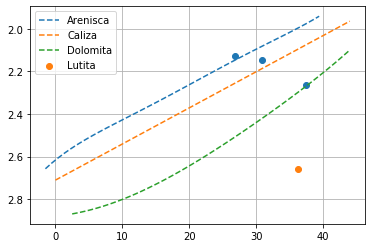

In [117]:
#plt.scatter (pArena[:,0], pArena[:,1])
plt.plot(arena[:,0], arena[:,1],'--', label='Arenisca')
plt.plot(caliza[:,0], caliza[:,1],'--', label='Caliza')
plt.plot(dolomita[:,0], dolomita[:,1],'--', label='Dolomita')
plt.scatter(ptos[:,1], ptos[:,0])
plt.scatter(lutita[9,0], lutita[9,1], label='Lutita')
# plt.scatter(lutita[0][0], lutita[0][1], label='Lutita')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [118]:
lit=[]
por=[]
for i in range(len(ptos)):
    [temp1, temp2]=clasificarLito(arena, caliza, dolomita, lutita, ptos[i, 1], ptos[i,0])
    lit.append(temp1)
    por.append(temp2)

## Visualización de los resultados obtenidos

Finalmente, la información obtenida es expuesta en un gráfico final. Antes de realizar dicho gráfico, debido a que el contenido del gráfico puede variar dependiendo si se cuenta con ciertos registros o no, primero se hace un conteo de gráficos a realizar y consecutivamente se van desplegando las imágenes respectivas en función de los registros o cálculos que se pudieron realizar.

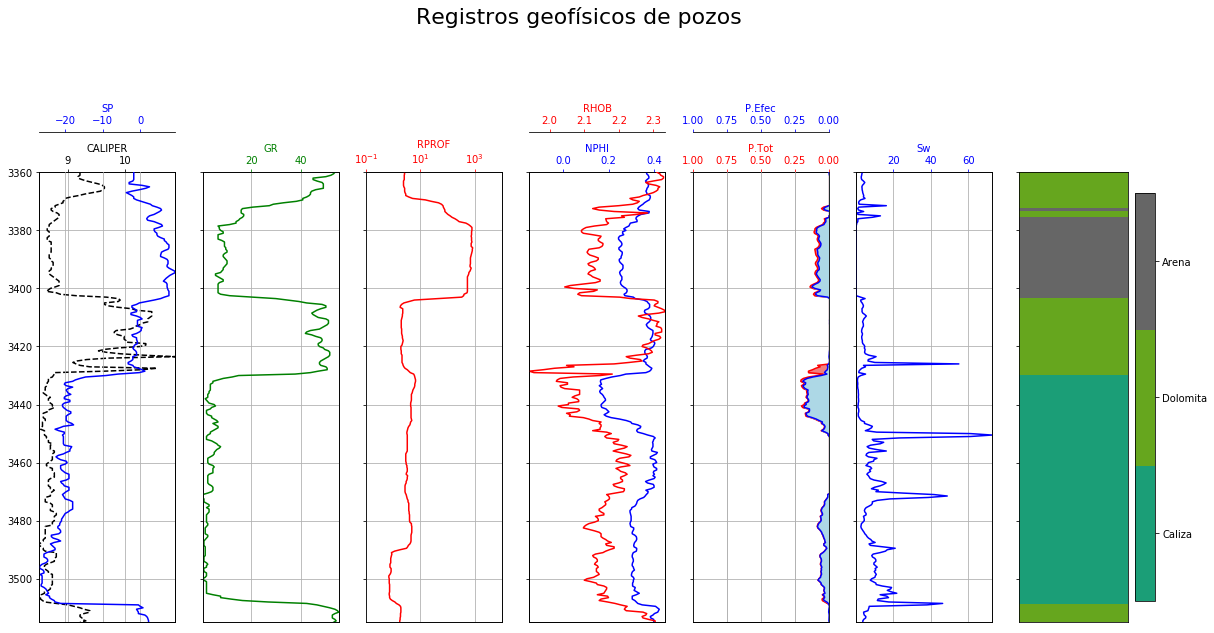

In [119]:
#Gráfica
i=0

#Numero de gráficos
if ('CALIPER' in df.columns or 'SP' in df.columns):    
    i+=1
if ('GR' in df.columns):
    i+=1
if ('RCERC' in df.columns or 'RMED' in df.columns or 'RPROF' in df.columns):    
    i+=1
if ('NPHI' in df.columns or 'RHOB' in df.columns):    
    i+=1
if ('Clasif' in df.columns):
    i+=1
if ('DT' in df.columns):  
    i+=1
if ('PTOT' in df.columns or 'PEfec' in df.columns):  
    i+=1
if ('Sw' in df.columns or 'Sxo' in df.columns):  
    i+=1

fig, ax = plt.subplots(nrows=1, ncols=i, figsize=(20,10), sharey=True)
fig.suptitle("Registros geofísicos de pozos", fontsize=22)
fig.subplots_adjust(top=0.75,wspace=0.2)

for axes in ax:
        axes.set_ylim (log.start,log.stop)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
i=-1

#CARRIL 1
#CALI
if ('CALIPER' in df.columns or 'SP' in df.columns):    
    i+=1

if ('CALIPER' in df.columns):    
    color='black'
    ax1=ax[i].twiny()
    ax1.set_xlim(min(df.CALIPER),max(df.CALIPER))
    ax1.spines['top'].set_position(('outward',0))
    ax1.plot(df.CALIPER, df.DEPTH, '--', color=color)
    ax1.set_xlabel('CALIPER',color=color)    
    ax1.tick_params(axis='x', colors=color)
    ax1.grid(True)
#SP
if ('SP' in df.columns):
    color='blue'
    ax2=ax[i].twiny()
    ax2.set_xlim(min(df.SP),max(df.SP))
    ax2.spines['top'].set_position(('outward',40))
    ax2.plot(df.SP, df.DEPTH, color=color)
    ax2.set_xlabel('SP',color=color)    
    ax2.tick_params(axis='x', colors=color)
    ax2.grid(True)


#CARRIL 2
#GR
if ('GR' in df.columns):
    i+=1
    color='green'
    ax3=ax[i].twiny()
    ax3.set_xlim(min(df.GR),max(df.GR))
    ax3.spines['top'].set_position(('outward',0))
    ax3.plot(df.GR, df.DEPTH, color=color)
    ax3.set_xlabel('GR',color=color)    
    ax3.tick_params(axis='x', colors=color)
    ax3.grid(True)


# #CARRIL 3
if ('RCERC' in df.columns or 'RMED' in df.columns or 'RPROF' in df.columns):    
    i+=1
#RPROFUNDA
if ('RPROF' in df.columns):    
    color='red'
    ax4=ax[i].twiny()
    ax4.set_xlim(0.1,10000)
    ax4.set_xscale('log')
    ax4.grid(True)
    ax4.spines['top'].set_position(('outward',0))
    ax4.set_xlabel('RPROF',color=color)    
    ax4.plot(df.RPROF ,df.DEPTH, color=color)
    ax4.tick_params(axis='x', colors=color)  

#RMEDIA
if ('RMED' in df.columns):    
    color='orange'
    ax5=ax[i].twiny()
    ax5.set_xlim(0.1,10000)
    ax5.set_xscale('log')
    ax5.grid(True)
    ax5.spines['top'].set_position(('outward',40))
    ax5.set_xlabel('RMED',color=color)    
    ax5.plot(df.RMED ,df.DEPTH, color=color)
    ax5.tick_params(axis='x', colors=color)  

#RSOMERA
if ('RCERC' in df.columns):    
    color='yellow'
    ax6=ax[i].twiny()
    ax6.set_xlim(0.1,10000)
    ax6.set_xscale('log')
    ax6.grid(True)
    ax6.spines['top'].set_position(('outward',80))
    ax6.set_xlabel('RSOM',color=color)    
    ax6.plot(df.RCERC ,df.DEPTH, color=color)
    ax6.tick_params(axis='x', colors=color)  


#CARRIL 4
if ('NPHI' in df.columns or 'RHOB' in df.columns):    
    i+=1
#NPHI
if ('NPHI' in df.columns):   
    color='blue'
    ax7=ax[i].twiny()
    ax7.set_xlim(0.45,-0.15)
    ax7.invert_xaxis()
    ax7.plot(df.NPHI, df.DEPTH, color=color) 
    ax7.spines['top'].set_position(('outward',0))
    ax7.set_xlabel('NPHI',color=color)   
    ax7.tick_params(axis='x', colors=color)

#RHOB
if ('RHOB' in df.columns):   
    color2='red'
    ax8=ax[i].twiny()
    ax8.set_xlim(min(df.RHOB),max(df.RHOB))
    ax8.plot(df.RHOB, df.DEPTH ,label='RHOB', color=color2) 
    ax8.spines['top'].set_position(('outward',40))
    ax8.set_xlabel('RHOB',color=color2)   
    ax8.tick_params(axis='x', colors=color2)
    
    
#CARRIL 5
#DT
if ('DT' in df.columns):  
    i+=1
    color='purple'
    ax9=ax[i].twiny()
    ax9.set_xlim(min(df.DT),max(df.DT))
    ax9.invert_xaxis()
    ax9.plot(df.DT, df.DEPTH, color=color) 
    ax9.spines['top'].set_position(('outward',0))
    ax9.set_xlabel('DT',color=color)   
    ax9.tick_params(axis='x', colors=color)    
    
    
#CARRIL 6
#Porosidad total
if ('PTOT' in df.columns or 'PEfec' in df.columns):  
    i+=1
if ('PTOT' in df.columns):  
    color='red'
    ax10=ax[i].twiny()
    ax10.set_xlim(1,0)
    ax10.spines['top'].set_position(('outward',0))
    ax10.plot(df.PTOT, df.DEPTH, color=color)
    ax10.fill_betweenx(df.DEPTH,0,df.PTOT,color='lightcoral')
    ax10.set_xlabel('P.Tot',color=color)   
    ax10.tick_params(axis='x', colors=color)
    ax10.grid(True)
if ('PTOT' in df.columns):  
    color='blue'
    ax11=ax[i].twiny()
    ax11.set_xlim(1,0)
    ax11.spines['top'].set_position(('outward',40))
    ax11.plot(df.PEfec, df.DEPTH, color=color)
    ax11.fill_betweenx(df.DEPTH,0,df.PEfec,color='lightblue')
    ax11.set_xlabel('P.Efec',color=color)   
    ax11.tick_params(axis='x', colors=color)
    ax11.grid(True)


#CARRIL 7
if ('Sw' in df.columns or 'Sxo' in df.columns):  
    i+=1
if ('Sw' in df.columns):
    color='blue'
    ax11=ax[i].twiny()
    ax11.set_xlim(min(df.Sw),max(df.Sw))
    ax11.spines['top'].set_position(('outward',0))
    ax11.plot(df.Sw, df.DEPTH, color=color)
    ax11.set_xlabel('Sw',color=color)   
    ax11.tick_params(axis='x', colors=color)
    ax11.grid(True)
if ('Sxo' in df.columns):
    color='lightgreen'
    ax11=ax[i].twiny()
    ax11.set_xlim(min(df.Sxo),max(df.Sxo))
    ax11.spines['top'].set_position(('outward',40))
    ax11.plot(df.Sxo, df.DEPTH, color=color)
    ax11.set_xlabel('Sxo',color=color)   
    ax11.tick_params(axis='x', colors=color)
    ax11.grid(True)
    


# CARRIL 8
if ('Clasif' in df.columns):
    i+=1
    X=np.arange(0,1,0.1)
    Y=df.DEPTH.values
    Z=df.Clasif.values
    Z=Z.reshape(len(Z),1)
    Z2=np.repeat(Z, 10, 1)

    ax20=ax[i]
    cmap = plt.get_cmap('Dark2', np.max(Z)-np.min(Z)+1)  
    c = ax20.pcolor(X,Y,Z2, cmap=cmap,vmin=np.min(Z)-.5, vmax=np.max(Z)+.5)
    cbar = fig.colorbar(c, ax=ax20, ticks=np.arange(np.min(Z),np.max(Z)+1))
    cbar.ax.set_yticklabels(lit) 
    #fig.colorbar(c, ax=ax20, ticks=['Arena','Caliza','Lutita'])
    
#     cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
#     cbar.ax.set_yticklabels(['< -1', '0', '> 1']) 
